## DESPLIEGUE Y MONITORIZACIÓN DEL MODELO
__INTEGRANTES__
   - DIEGO ALONSO
   - ALVARO FERREÑO
   -  HAMZA TRIKI

In [187]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error
from sklearn.feature_selection import RFE, RFECV
from sklearn.base import clone
from sklearn.linear_model import Ridge, Lasso, ElasticNet, LinearRegression
from sklearn.preprocessing import OneHotEncoder, StandardScaler, PolynomialFeatures
from sklearn.model_selection import train_test_split, GridSearchCV, KFold, RandomizedSearchCV
from scipy.stats import uniform
from sklearn.pipeline import Pipeline

In [188]:
from sklearn.preprocessing import OneHotEncoder
import joblib

def one_hot_encoder(X_train, X_test):
    """Recibe X_train y X_test y les realiza el one-hot encoding"""
    encoded_data = []
    
    # Inicializar el encoder
    encoder = OneHotEncoder(sparse_output =False)
    
    # Obtener las columnas categóricas de X_train
    categorical_columns = X_train.select_dtypes(include=["object"]).columns
    
    # Ajustar el encoder solo en X_train
    encoded_columns_train = encoder.fit_transform(X_train[categorical_columns])
    new_columns = encoder.get_feature_names_out(categorical_columns)
    data_encoded_train = pd.DataFrame(encoded_columns_train, columns=new_columns)
    
    # Concatenar las columnas codificadas con el resto de X_train
    X_train.reset_index(drop=True, inplace=True)
    data_encoded_train.reset_index(drop=True, inplace=True)
    X_train_encoded = pd.concat([X_train.drop(categorical_columns, axis=1), data_encoded_train], axis=1)
    encoded_data.append(X_train_encoded)
    
    # Aplicar transformación a X_test
    encoded_columns_test = encoder.transform(X_test[categorical_columns])
    data_encoded_test = pd.DataFrame(encoded_columns_test, columns=new_columns)
    X_test.reset_index(drop=True, inplace=True)
    data_encoded_test.reset_index(drop=True, inplace=True)
    X_test_encoded = pd.concat([X_test.drop(categorical_columns, axis=1), data_encoded_test], axis=1)
    encoded_data.append(X_test_encoded)
    
    # Guardar el encoder ajustado para su uso posterior
    joblib.dump(encoder, 'encoderProduccion.pkl')
    
    return encoded_data


def standardize(X_train,X_test):
    """recibe los datos y los estandariza"""
    scaler = StandardScaler()
    variables_estandarizar = ["Dormitorios","Superficie","Num_baños","Año_de_construccion","Latitud","Longitud"]
    X_train_encoded_scaled = X_train.copy()
    X_test_encoded_scaled = X_test.copy()
    X_train_encoded_scaled[variables_estandarizar] = scaler.fit_transform(X_train[variables_estandarizar])
    X_test_encoded_scaled[variables_estandarizar] = scaler.transform(X_test[variables_estandarizar])
    joblib.dump(scaler, 'scalerProduccion.pkl')
    return X_train_encoded_scaled,X_test_encoded_scaled
def calculate_error(model,X,y):
    """ recibe un modelo y los datos y calcula el error del modelo"""
    test_predictions = model.predict(X)
    test_mse = mean_absolute_error(y, test_predictions)
    return test_mse
def concat_input_output(residuos,X_test,y_test,X_train,y_train):
    residuos.name = "residuos"
    residuosTrain.name = "residuos"
    datosTestConResiduos = pd.concat([X_test,y_test.reset_index(drop =True),residuos.reset_index(drop = True)],axis =1)
    datosTrainConResiduos = pd.concat([X_train,y_train.reset_index(drop =True),residuosTrain.reset_index(drop = True)],axis=1)
    return datosTestConResiduos,datosTrainConResiduos
def obtener_distritos_con_gran_error(y_test,residuos,X_test):
    y_test_reset = y_test.reset_index(drop=True)
    residuos_reset = residuos.reset_index(drop=True)
    mediana_por_distrito = pd.DataFrame({'Residuos': residuos_reset, 'Distrito/Ciudad': X_test['distrito/ciudad']}).groupby('Distrito/Ciudad').median()
    distritos_con_residuos_altos = mediana_por_distrito[mediana_por_distrito['Residuos'] > 30000]
    distritos_con_residuos_bajos = mediana_por_distrito[mediana_por_distrito['Residuos'] < 30000]

    return distritos_con_residuos_altos,distritos_con_residuos_bajos

In [189]:
DatosTrain =pd.read_parquet("TrainFinalDefinitvo.parquet")
DatosTest = pd.read_parquet("TestFinalDefinitvo.parquet")
DistritosProduccion = pd.read_csv("DistritosErrorMenorQue30000.csv")

Realizando este estudio hemos encontrado un error en los datos, y es que en el conjunto de train hay una casa que vale 900€, y hemos decidido quitarla porque lo más probable es que sea el precio del alquiler de la casa.

## Monitorización de la deriva

### Análisis variables objetivo

In [190]:
estadisticas_descriptivas = DatosTrain['Precio'].describe()
print(estadisticas_descriptivas)

media = DatosTrain['Precio'].mean()
print("Media:", media)

mediana = DatosTrain['Precio'].median()
print("Mediana:", mediana)

desviacion_estandar = DatosTrain['Precio'].std()
print("Desviación estándar:", desviacion_estandar)

minimo = DatosTrain['Precio'].min()
maximo = DatosTrain['Precio'].max()
print("Mínimo:", minimo)
print("Máximo:", maximo)

count    1.551000e+03
mean     2.400527e+05
std      1.464803e+05
min      9.000000e+02
25%      1.470000e+05
50%      1.899000e+05
75%      2.825000e+05
max      1.350000e+06
Name: Precio, dtype: float64
Media: 240052.720825274
Mediana: 189900.0
Desviación estándar: 146480.27816002228
Mínimo: 900.0
Máximo: 1350000.0


In [191]:
estadisticas_descriptivas = DatosTest['Precio'].describe()
print(estadisticas_descriptivas)

media = DatosTest['Precio'].mean()
print("Media:", media)

mediana = DatosTest['Precio'].median()
print("Mediana:", mediana)

desviacion_estandar = DatosTest['Precio'].std()
print("Desviación estándar:", desviacion_estandar)

minimo = DatosTest['Precio'].min()
maximo = DatosTest['Precio'].max()
print("Mínimo:", minimo)
print("Máximo:", maximo)

count        92.000000
mean     221705.315217
std       90914.127150
min       76000.000000
25%      159750.000000
50%      202000.000000
75%      251000.000000
max      529000.000000
Name: Precio, dtype: float64
Media: 221705.3152173913
Mediana: 202000.0
Desviación estándar: 90914.12714977271
Mínimo: 76000.0
Máximo: 529000.0


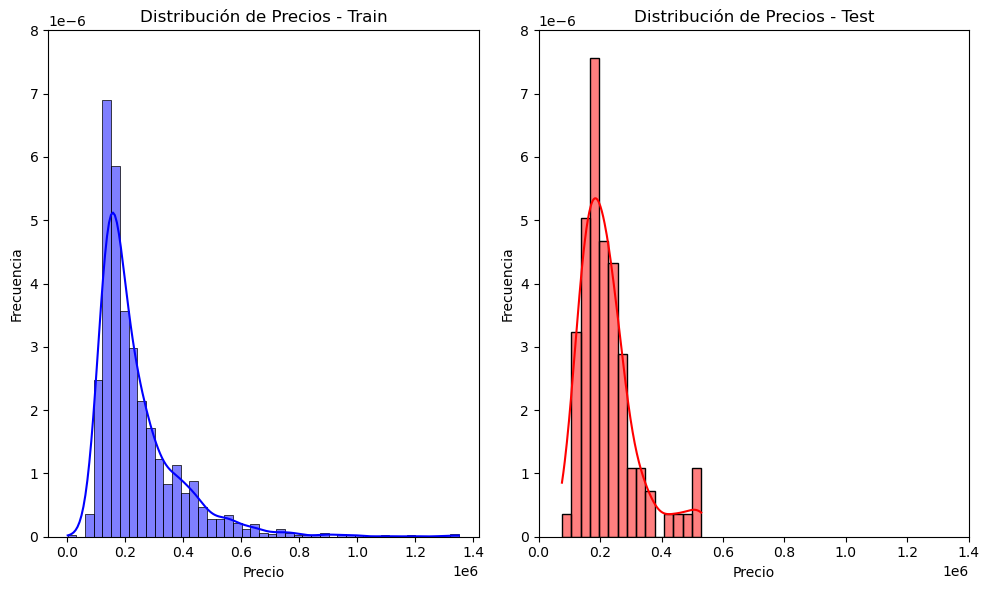

In [192]:
import matplotlib.pyplot as plt
import seaborn as sns

fig, axs = plt.subplots(1, 2, figsize=(10, 6))

sns.histplot(DatosTrain['Precio'],bins =45, color='blue', kde=True, label='Train', stat='density', ax=axs[0])

axs[0].set_title('Distribución de Precios - Train')
axs[0].set_xlabel('Precio')
axs[0].set_ylabel('Frecuencia')
axs[0].set_xticks([0,200000,400000,600000,800000,1000000,1200000,1400000])
axs[0].set_yticks([0,0.000001,0.000002,0.000003,0.000004,0.000005,0.000006,0.000007,.000008])

sns.histplot(DatosTest['Precio'], color='red', kde=True, label='Test', stat='density', bins=15, ax=axs[1])

axs[1].set_title('Distribución de Precios - Test')
axs[1].set_xlabel('Precio')
axs[1].set_ylabel('Frecuencia')
axs[1].set_xticks([0,200000,400000,600000,800000,1000000,1200000,1400000])
axs[1].set_yticks([0,0.000001,0.000002,0.000003,0.000004,0.000005,0.000006,0.000007,.000008])


plt.tight_layout()  
plt.show()


#### T student

In [193]:
from scipy.stats import ttest_ind

t_statistic, p_value = ttest_ind(DatosTrain['Precio'], DatosTest['Precio'])

print("Estadístico t:", t_statistic)
print("Valor p:", p_value)

alpha = 0.05
if p_value < alpha:
    print("Se rechaza la hipótesis nula. Hay una diferencia significativa entre las distribuciones.")
else:
    print("No se rechaza la hipótesis nula. No hay una diferencia significativa entre las distribuciones.")

Estadístico t: 1.1877053289333845
Valor p: 0.23512140328697034
No se rechaza la hipótesis nula. No hay una diferencia significativa entre las distribuciones.


#### Kolmogorov-Smirnov

In [194]:
from scipy.stats import ks_2samp

statistic, p_value = ks_2samp(DatosTrain['Precio'], DatosTest['Precio'])

print("Estadístico de la prueba:", statistic)
print("Valor p:", p_value)

alpha = 0.05
if p_value < alpha:
    print("Se rechaza la hipótesis nula. Hay una diferencia significativa entre las distribuciones.")
else:
    print("No se rechaza la hipótesis nula. No hay una diferencia significativa entre las distribuciones.")

Estadístico de la prueba: 0.11243797830291817
Valor p: 0.2052642197189784
No se rechaza la hipótesis nula. No hay una diferencia significativa entre las distribuciones.


### Análisis variables importantes

__Superficie__

In [195]:
estadisticas_descriptivas = DatosTrain['Superficie'].describe()
print(estadisticas_descriptivas)

media = DatosTrain['Superficie'].mean()
print("Media:", media)

mediana = DatosTrain['Superficie'].median()
print("Mediana:", mediana)

desviacion_estandar = DatosTrain['Superficie'].std()
print("Desviación estándar:", desviacion_estandar)

minimo = DatosTrain['Superficie'].min()
maximo = DatosTrain['Superficie'].max()
print("Mínimo:", minimo)
print("Máximo:", maximo)

count    1551.000000
mean       94.473243
std        47.604599
min        20.000000
25%        64.000000
50%        80.000000
75%       110.000000
max       299.000000
Name: Superficie, dtype: float64
Media: 94.47324306898776
Mediana: 80.0
Desviación estándar: 47.60459885338646
Mínimo: 20.0
Máximo: 299.0


In [196]:
estadisticas_descriptivas = DatosTest['Superficie'].describe()
print(estadisticas_descriptivas)

media = DatosTest['Superficie'].mean()
print("Media:", media)

mediana = DatosTest['Superficie'].median()
print("Mediana:", mediana)

desviacion_estandar = DatosTest['Superficie'].std()
print("Desviación estándar:", desviacion_estandar)

minimo = DatosTest['Superficie'].min()
maximo = DatosTest['Superficie'].max()
print("Mínimo:", minimo)
print("Máximo:", maximo)

count     92.000000
mean      85.586957
std       36.456252
min       39.000000
25%       59.500000
50%       78.000000
75%      100.000000
max      210.000000
Name: Superficie, dtype: float64
Media: 85.58695652173913
Mediana: 78.0
Desviación estándar: 36.45625172088528
Mínimo: 39.0
Máximo: 210.0


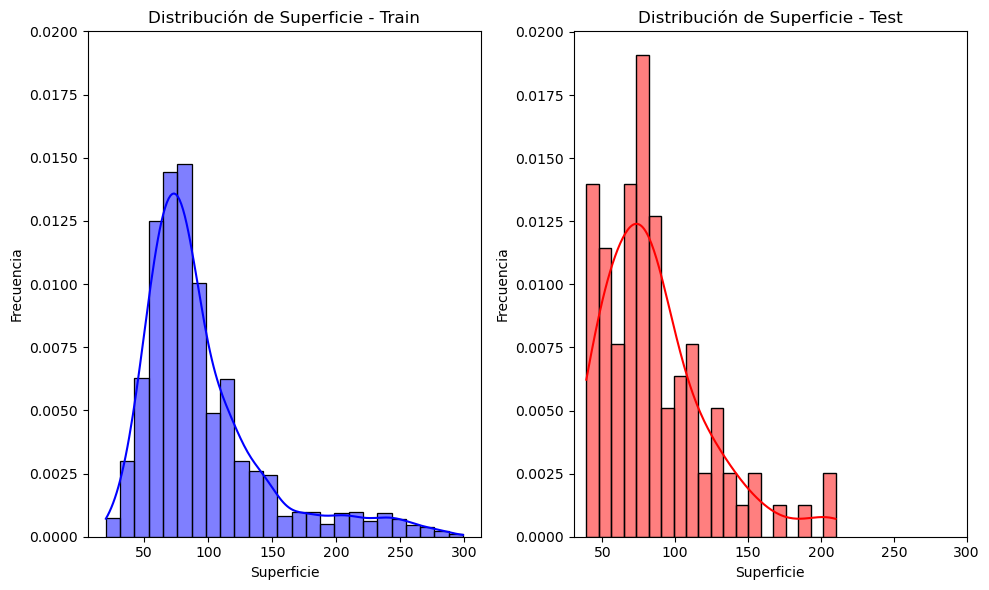

In [197]:
import seaborn as sns
import matplotlib.pyplot as plt

fig, axs = plt.subplots(1, 2, figsize=(10, 6))

sns.histplot(DatosTrain['Superficie'],bins =25, color='blue', kde=True, label='Train', stat='density', ax=axs[0])

axs[0].set_title('Distribución de Superficie - Train')
axs[0].set_xlabel('Superficie')
axs[0].set_ylabel('Frecuencia')
axs[0].set_xticks([50,100,150,200,250,300])
axs[0].set_yticks([0,0.0025,0.0050,0.0075,0.0100,0.0125,0.0150,0.0175,0.0200])


sns.histplot(DatosTest['Superficie'], color='red', kde=True, label='Test', stat='density', bins=20, ax=axs[1])

axs[1].set_title('Distribución de Superficie - Test')
axs[1].set_xlabel('Superficie')
axs[1].set_ylabel('Frecuencia')
axs[1].set_xticks([50,100,150,200,250,300])
axs[1].set_yticks([0,0.0025,0.0050,0.0075,0.0100,0.0125,0.0150,0.0175,0.0200])



plt.tight_layout()  
plt.show()


##### T student

In [198]:
from scipy.stats import ttest_ind

t_statistic, p_value = ttest_ind(DatosTrain['Superficie'], DatosTest['Superficie'])

print("Estadístico t:", t_statistic)
print("Valor p:", p_value)

alpha = 0.05
if p_value < alpha:
    print("Se rechaza la hipótesis nula. Hay una diferencia significativa entre las distribuciones.")
else:
    print("No se rechaza la hipótesis nula. No hay una diferencia significativa entre las distribuciones.")

Estadístico t: 1.759908172365845
Valor p: 0.0786096723719506
No se rechaza la hipótesis nula. No hay una diferencia significativa entre las distribuciones.


##### Kolmogorov-Smirnov 

In [199]:
from scipy.stats import ks_2samp

statistic, p_value = ks_2samp(DatosTrain['Superficie'], DatosTest['Superficie'])

print("Estadístico de la prueba:", statistic)
print("Valor p:", p_value)

alpha = 0.05
if p_value < alpha:
    print("Se rechaza la hipótesis nula. Hay una diferencia significativa entre las distribuciones.")
else:
    print("No se rechaza la hipótesis nula. No hay una diferencia significativa entre las distribuciones.")

Estadístico de la prueba: 0.08558293387155552
Valor p: 0.5189274475567917
No se rechaza la hipótesis nula. No hay una diferencia significativa entre las distribuciones.


#### Año de construcción

count    1551.000000
mean     1973.248872
std        23.000111
min      1860.000000
25%      1965.000000
50%      1973.000000
75%      1985.000000
max      2024.000000
Name: Año_de_construccion, dtype: float64
Media: 1973.2488716956802
Mediana: 1973.0
Desviación estándar: 23.000111297423157
Mínimo: 1860.0
Máximo: 2024.0
count      92.000000
mean     1974.706522
std        21.756665
min      1900.000000
25%      1965.000000
50%      1974.500000
75%      1992.000000
max      2023.000000
Name: Año_de_construccion, dtype: float64
Media: 1974.7065217391305
Mediana: 1974.5
Desviación estándar: 21.75666528841333
Mínimo: 1900.0
Máximo: 2023.0


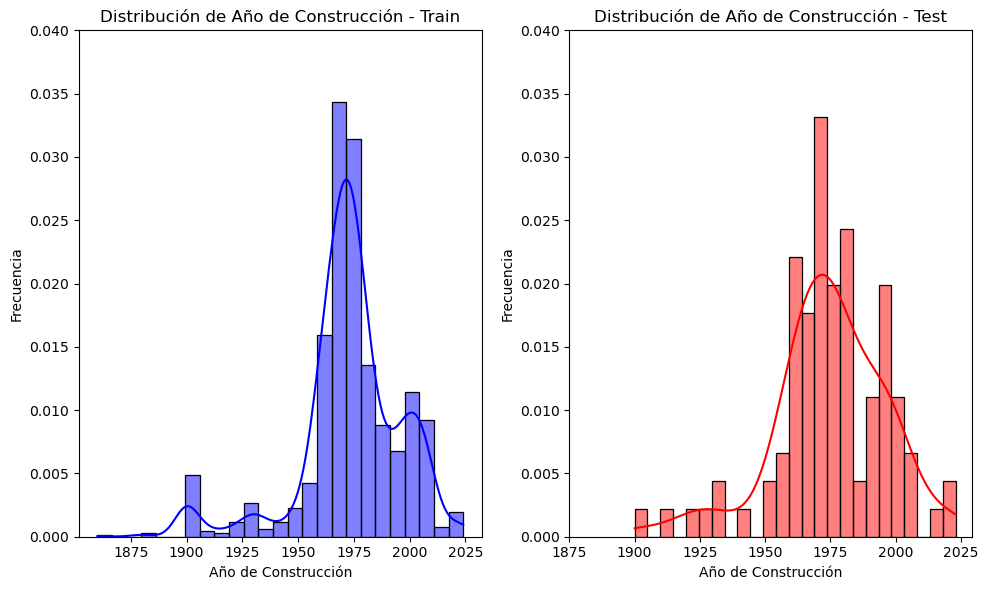

T STUDENT:
Estadístico t: -0.592345218677889
Valor p: 0.5537010482502819
No se rechaza la hipótesis nula. No hay una diferencia significativa entre las distribuciones.
Kolmogorov-Smirnov:
Estadístico de la prueba: 0.08938833291284726
Valor p: 0.4635084914282085
No se rechaza la hipótesis nula. No hay una diferencia significativa entre las distribuciones.


In [200]:
estadisticas_descriptivas = DatosTrain['Año_de_construccion'].describe()
print(estadisticas_descriptivas)

media = DatosTrain['Año_de_construccion'].mean()
print("Media:", media)

mediana = DatosTrain['Año_de_construccion'].median()
print("Mediana:", mediana)

desviacion_estandar = DatosTrain['Año_de_construccion'].std()
print("Desviación estándar:", desviacion_estandar)

minimo = DatosTrain['Año_de_construccion'].min()
maximo = DatosTrain['Año_de_construccion'].max()
print("Mínimo:", minimo)
print("Máximo:", maximo)

estadisticas_descriptivas = DatosTest['Año_de_construccion'].describe()
print(estadisticas_descriptivas)

media = DatosTest['Año_de_construccion'].mean()
print("Media:", media)

mediana = DatosTest['Año_de_construccion'].median()
print("Mediana:", mediana)

desviacion_estandar = DatosTest['Año_de_construccion'].std()
print("Desviación estándar:", desviacion_estandar)

minimo = DatosTest['Año_de_construccion'].min()
maximo = DatosTest['Año_de_construccion'].max()
print("Mínimo:", minimo)
print("Máximo:", maximo)


fig, axs = plt.subplots(1, 2, figsize=(10, 6))

sns.histplot(DatosTrain['Año_de_construccion'],bins =25 ,color='blue', kde=True, label='Train', stat='density', ax=axs[0])

axs[0].set_title('Distribución de Año de Construcción - Train')
axs[0].set_xlabel('Año de Construcción')
axs[0].set_ylabel('Frecuencia')
axs[0].set_xticks([1875,1900,1925,1950,1975,2000,2025])
axs[0].set_yticks([0,0.005,0.010,0.015,0.020,0.025,0.030,0.035,0.040])


sns.histplot(DatosTest['Año_de_construccion'],color='red', kde=True, label='Test', stat='density', bins=25, ax=axs[1])

axs[1].set_title('Distribución de Año de Construcción - Test')
axs[1].set_xlabel('Año de Construcción')
axs[1].set_ylabel('Frecuencia')
axs[1].set_xticks([1875,1900,1925,1950,1975,2000,2025])
axs[1].set_yticks([0,0.005,0.010,0.015,0.020,0.025,0.030,0.035,0.040])



plt.tight_layout()  
plt.show()
# T student

from scipy.stats import ttest_ind

t_statistic, p_value = ttest_ind(DatosTrain['Año_de_construccion'], DatosTest['Año_de_construccion'])

print("T STUDENT:")
print("Estadístico t:", t_statistic)
print("Valor p:", p_value)

alpha = 0.05
if p_value < alpha:
    print("Se rechaza la hipótesis nula. Hay una diferencia significativa entre las distribuciones.")
else:
    print("No se rechaza la hipótesis nula. No hay una diferencia significativa entre las distribuciones.")

# Kolmogorov-Smirnov 

from scipy.stats import ks_2samp

statistic, p_value = ks_2samp(DatosTrain['Año_de_construccion'], DatosTest['Año_de_construccion'])

print("Kolmogorov-Smirnov:")
print("Estadístico de la prueba:", statistic)
print("Valor p:", p_value)

alpha = 0.05
if p_value < alpha:
    print("Se rechaza la hipótesis nula. Hay una diferencia significativa entre las distribuciones.")
else:
    print("No se rechaza la hipótesis nula. No hay una diferencia significativa entre las distribuciones.")

#### Dormitorios

count    1551.000000
mean        2.776918
std         0.960784
min         1.000000
25%         2.000000
50%         3.000000
75%         3.000000
max        11.000000
Name: Dormitorios, dtype: float64
Media: 2.7769181173436492
Mediana: 3.0
Desviación estándar: 0.9607838428313349
Mínimo: 1.0
Máximo: 11.0
count    92.000000
mean      2.597826
std       0.826216
min       1.000000
25%       2.000000
50%       3.000000
75%       3.000000
max       5.000000
Name: Dormitorios, dtype: float64
Media: 2.597826086956522
Mediana: 3.0
Desviación estándar: 0.8262158221714823
Mínimo: 1.0
Máximo: 5.0


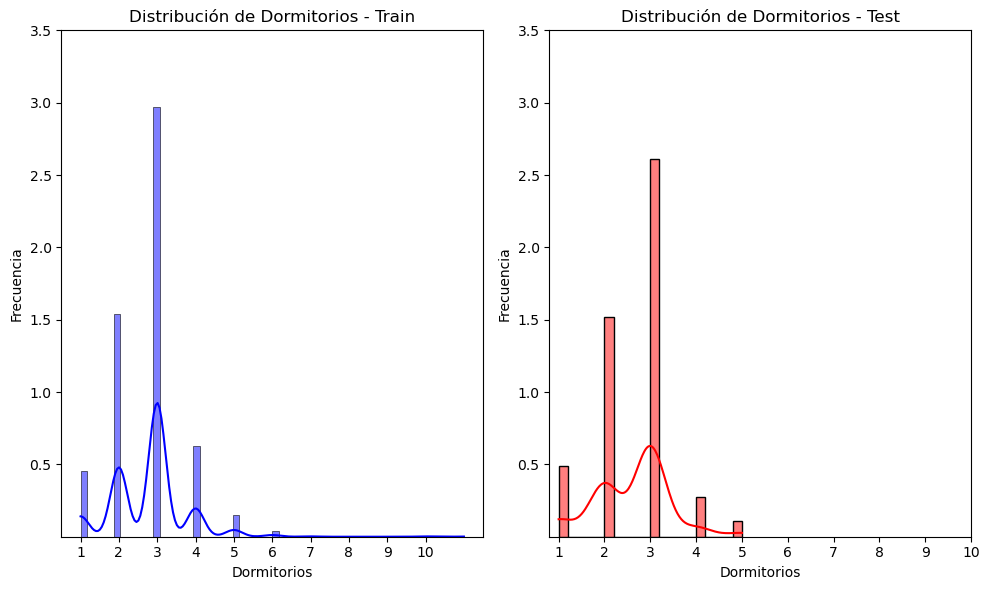

T STUDENT:
Estadístico t: 1.7498119921128952
Valor p: 0.08033766580511445
No se rechaza la hipótesis nula. No hay una diferencia significativa entre las distribuciones.
Kolmogorov-Smirnov:
Estadístico de la prueba: 0.0676912510862557
Valor p: 0.7940844332555438
No se rechaza la hipótesis nula. No hay una diferencia significativa entre las distribuciones.


In [201]:
estadisticas_descriptivas = DatosTrain['Dormitorios'].describe()
print(estadisticas_descriptivas)

media = DatosTrain['Dormitorios'].mean()
print("Media:", media)

mediana = DatosTrain['Dormitorios'].median()
print("Mediana:", mediana)

desviacion_estandar = DatosTrain['Dormitorios'].std()
print("Desviación estándar:", desviacion_estandar)

minimo = DatosTrain['Dormitorios'].min()
maximo = DatosTrain['Dormitorios'].max()
print("Mínimo:", minimo)
print("Máximo:", maximo)

estadisticas_descriptivas = DatosTest['Dormitorios'].describe()
print(estadisticas_descriptivas)

media = DatosTest['Dormitorios'].mean()
print("Media:", media)

mediana = DatosTest['Dormitorios'].median()
print("Mediana:", mediana)

desviacion_estandar = DatosTest['Dormitorios'].std()
print("Desviación estándar:", desviacion_estandar)

minimo = DatosTest['Dormitorios'].min()
maximo = DatosTest['Dormitorios'].max()
print("Mínimo:", minimo)
print("Máximo:", maximo)


fig, axs = plt.subplots(1, 2, figsize=(10, 6))

sns.histplot(DatosTrain['Dormitorios'], color='blue', kde=True, label='Train', stat='density', ax=axs[0])

axs[0].set_title('Distribución de Dormitorios - Train')
axs[0].set_xlabel('Dormitorios')
axs[0].set_ylabel('Frecuencia')
axs[0].set_xticks([1,2,3,4,5,6,7,8,9,10])
axs[0].set_yticks([0.5,1,1.5,2,2.5,3,3.5])


sns.histplot(DatosTest['Dormitorios'], color='red', kde=True, label='Test', stat='density', bins=20, ax=axs[1])

axs[1].set_title('Distribución de Dormitorios - Test')
axs[1].set_xlabel('Dormitorios')
axs[1].set_ylabel('Frecuencia')
axs[1].set_xticks([1,2,3,4,5,6,7,8,9,10])
axs[1].set_yticks([0.5,1,1.5,2,2.5,3,3.5])



plt.tight_layout()  
plt.show()


from scipy.stats import ttest_ind

t_statistic, p_value = ttest_ind(DatosTrain['Dormitorios'], DatosTest['Dormitorios'])

print("T STUDENT:")
print("Estadístico t:", t_statistic)
print("Valor p:", p_value)

alpha = 0.05
if p_value < alpha:
    print("Se rechaza la hipótesis nula. Hay una diferencia significativa entre las distribuciones.")
else:
    print("No se rechaza la hipótesis nula. No hay una diferencia significativa entre las distribuciones.")

# Kolmogorov-Smirnov 

from scipy.stats import ks_2samp

statistic, p_value = ks_2samp(DatosTrain['Dormitorios'], DatosTest['Dormitorios'])

print("Kolmogorov-Smirnov:")
print("Estadístico de la prueba:", statistic)
print("Valor p:", p_value)

alpha = 0.05
if p_value < alpha:
    print("Se rechaza la hipótesis nula. Hay una diferencia significativa entre las distribuciones.")
else:
    print("No se rechaza la hipótesis nula. No hay una diferencia significativa entre las distribuciones.")

Separamos las variables de entrada y la variable respuesta en train y test

In [202]:
X_train = DatosTrain.drop(columns = "Precio")
y_train =  DatosTrain["Precio"]
X_test = DatosTest.drop(columns ="Precio")
y_test = DatosTest["Precio"]

Aplicamos las transformaciones necesarias (escalado y oneHotEnocoding)

In [203]:
X_train_encoded,X_test_encoded = one_hot_encoder(X_train,X_test)
X_train_encoded_scaled,X_test_encoded_scaled= standardize(X_train_encoded,X_test_encoded)

Reentrenamos el modelo de regresión polinomica y regularización ridge con los hiperparametros obtenidos en la etapa anterior de entrenamiento de modelos. Tambien reentrenamos con todo el conjunto de datos, es decir, train/test de la etapa anterior es ahora nuestro train.

In [204]:
from sklearn.preprocessing import PolynomialFeatures, StandardScaler

pipeline_polinomico_ridge = Pipeline([
    ("poly_features", PolynomialFeatures(degree=2)),  # Puedes ajustar el grado del polinomio aquí
    ("ridge_reg", Ridge(alpha=30))  # Regularización Ridge, puedes ajustar el parámetro de regularización alpha
])

pipeline_polinomico_ridge.fit(X_train_encoded_scaled, y_train)

Pipeline(steps=[('poly_features', PolynomialFeatures()),
                ('ridge_reg', Ridge(alpha=30))])

Calculamos el error con nuestro nuevo conjunto de test

In [205]:
calculate_error(pipeline_polinomico_ridge,X_test_encoded_scaled,y_test)

32897.26092255323

Guardamos en formato pickle nuestro modelo para utilizarlo posteriormente en nuestra aplicación web.

In [206]:
joblib.dump(pipeline_polinomico_ridge, 'modelo_produccion.pkl')

['modelo_produccion.pkl']

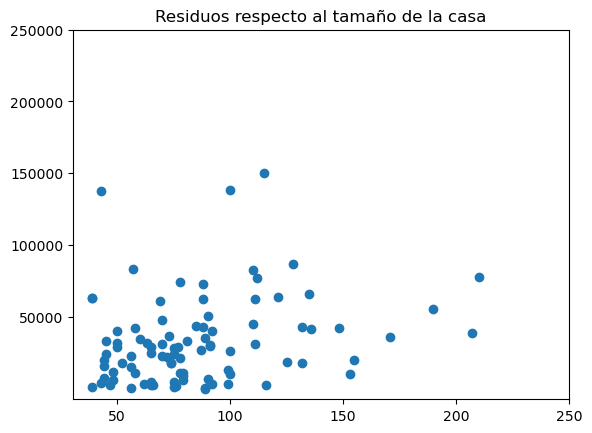

In [207]:
predicciones = pipeline_polinomico_ridge.predict(X_test_encoded_scaled)
residuos = abs(predicciones-y_test)
residuosTrain = abs(pipeline_polinomico_ridge.predict(X_train_encoded_scaled)-y_train)
plt.scatter(X_test_encoded["Superficie"],residuos)
plt.xticks([50,100,150,200,250])
plt.yticks([50000,100000,150000,200000,250000])
plt.title("Residuos respecto al tamaño de la casa")
plt.show()

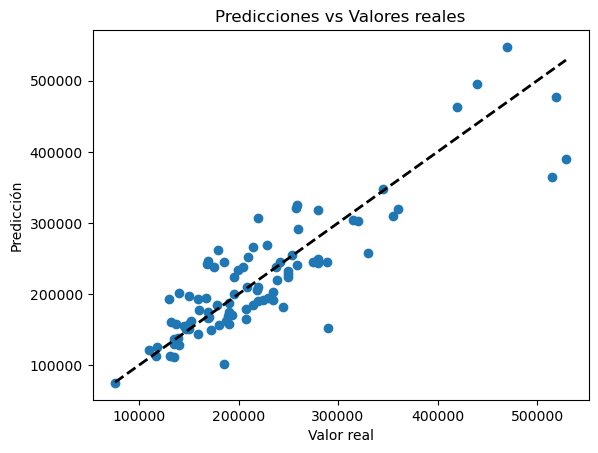

In [208]:
plt.scatter(y_test, pipeline_polinomico_ridge.predict(X_test_encoded_scaled))
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=2) # Línea diagonal
plt.xlabel("Valor real")
plt.ylabel("Predicción")
plt.title("Predicciones vs Valores reales")
plt.show()

Cargamos los resultados del test de la entrega anterior para realizar nuestro estudio

In [209]:
TestEntregaAnterior = pd.read_csv("datosTestEntrega3.csv")

In [210]:
datosTestConResiduos,datosTrainConResiduos = concat_input_output(residuos,X_test,y_test,X_train,y_train)

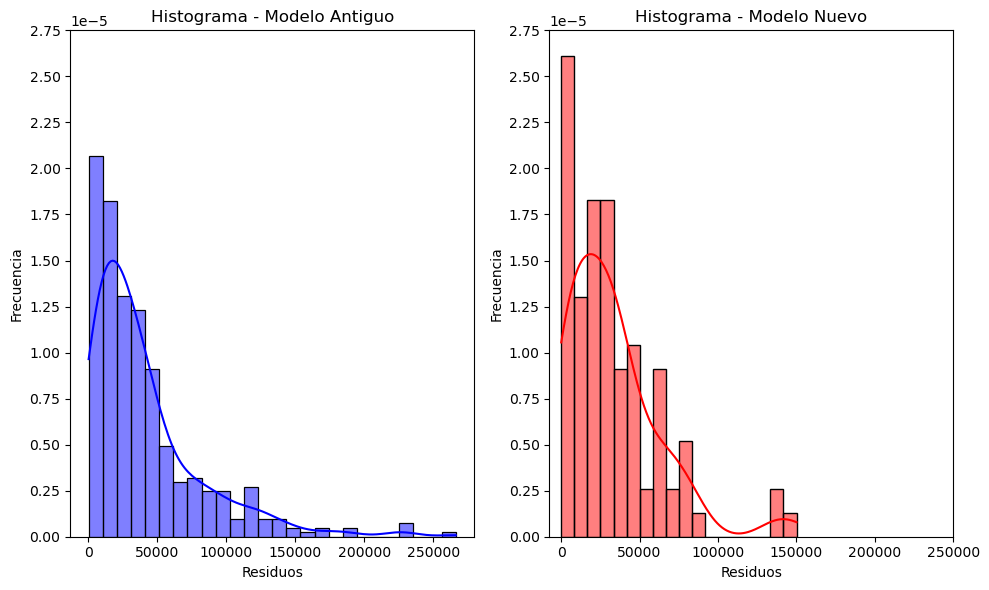

In [211]:
import seaborn as sns
import matplotlib.pyplot as plt

# Crear la figura y los ejes de las sub-gráficas
fig, axs = plt.subplots(1, 2, figsize=(10, 6))

# Gráfica para el "Modelo Antiguo"
sns.histplot(TestEntregaAnterior[TestEntregaAnterior["distrito/ciudad"].isin(DistritosProduccion["Distrito/Ciudad"].unique())]["residuos"], color='blue', alpha=0.5, label='Modelo Antiguo', kde=True, stat='density', ax=axs[0])

axs[0].set_xlabel('Residuos')
axs[0].set_ylabel('Frecuencia')
axs[0].set_title('Histograma - Modelo Antiguo')
axs[0].set_xticks([0,50000,100000,150000,200000,250000])
axs[0].set_yticks([0,0.0000025,0.0000050,0.0000075,0.0000100,0.0000125,0.0000150,0.0000175,0.0000200,0.0000225,0.0000250,0.0000275])


# Gráfica para el "Modelo Nuevo"
sns.histplot(datosTestConResiduos["residuos"],bins =18 ,color='red', alpha=0.5, label='Modelo Nuevo', kde=True, stat='density', ax=axs[1])

axs[1].set_xlabel('Residuos')
axs[1].set_ylabel('Frecuencia')
axs[1].set_title('Histograma - Modelo Nuevo')
axs[1].set_xticks([0,50000,100000,150000,200000,250000])
axs[1].set_yticks([0,0.0000025,0.0000050,0.0000075,0.0000100,0.0000125,0.0000150,0.0000175,0.0000200,0.0000225,0.0000250,0.0000275])



plt.tight_layout()  # Ajustar la disposición de las sub-gráficas para evitar solapamientos
plt.show()



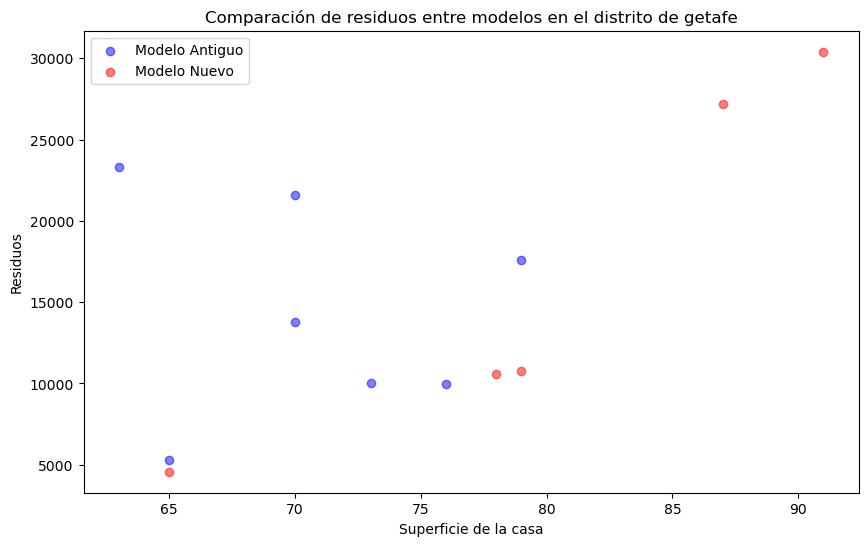

In [212]:
import matplotlib.pyplot as plt

# Datos del primer modelo
superficie_modelo1 = TestEntregaAnterior[TestEntregaAnterior["distrito/ciudad"]== "Getafe"]["Superficie"].values
residuos_modelo1 = TestEntregaAnterior[TestEntregaAnterior["distrito/ciudad"]== "Getafe"]["residuos"].values

# Datos del segundo modelo
superficie_modelo2 = datosTestConResiduos[datosTestConResiduos["distrito/ciudad"]== "Getafe"]["Superficie"].values
residuos_modelo2 = datosTestConResiduos[datosTestConResiduos["distrito/ciudad"]== "Getafe"]["residuos"].values



# Configuración del gráfico
plt.figure(figsize=(10, 6))
plt.scatter(superficie_modelo1, residuos_modelo1, color='b', label='Modelo Antiguo', alpha=0.5)
plt.scatter(superficie_modelo2, residuos_modelo2, color='r', label='Modelo Nuevo', alpha=0.5)
plt.xlabel('Superficie de la casa')
plt.ylabel('Residuos')
plt.title('Comparación de residuos entre modelos en el distrito de getafe')
plt.legend()
plt.show()


In [213]:
from scipy.stats import ttest_ind

t_statistic, p_value = ttest_ind(TestEntregaAnterior[TestEntregaAnterior["distrito/ciudad"].isin(DistritosProduccion["Distrito/Ciudad"].unique())]["residuos"],datosTestConResiduos["residuos"])

print("Estadístico t:", t_statistic)
print("Valor p:", p_value)

alpha = 0.05
if p_value < alpha:
    print("Se rechaza la hipótesis nula. Hay una diferencia significativa entre las distribuciones.")
else:
    print("No se rechaza la hipótesis nula. No hay una diferencia significativa entre las distribuciones.")

Estadístico t: 1.672509696096892
Valor p: 0.09506611522392358
No se rechaza la hipótesis nula. No hay una diferencia significativa entre las distribuciones.


In [214]:
from scipy.stats import ks_2samp

statistic, p_value = ks_2samp(TestEntregaAnterior[TestEntregaAnterior["distrito/ciudad"].isin(DistritosProduccion["Distrito/Ciudad"].unique())]["residuos"],datosTestConResiduos["residuos"])

print("Estadístico de la prueba:", statistic)
print("Valor p:", p_value)

alpha = 0.05
if p_value < alpha:
    print("Se rechaza la hipótesis nula. Hay una diferencia significativa entre las distribuciones.")
else:
    print("No se rechaza la hipótesis nula. No hay una diferencia significativa entre las distribuciones.")

Estadístico de la prueba: 0.09081699704304019
Valor p: 0.5337804441834814
No se rechaza la hipótesis nula. No hay una diferencia significativa entre las distribuciones.


In [215]:
df_peores,df_mejores =obtener_distritos_con_gran_error(y_test,residuos,X_test)

In [216]:
df_mejores_antiguos = pd.read_csv("DistritosErroresPequenios.csv")
df_merged = pd.merge(df_mejores,df_mejores_antiguos, on= "Distrito/Ciudad")
df =df_merged
distritosMayorFrecuencia = X_test["distrito/ciudad"].value_counts().head(6).index.values
df = df[df["Distrito/Ciudad"].isin(distritosMayorFrecuencia)]


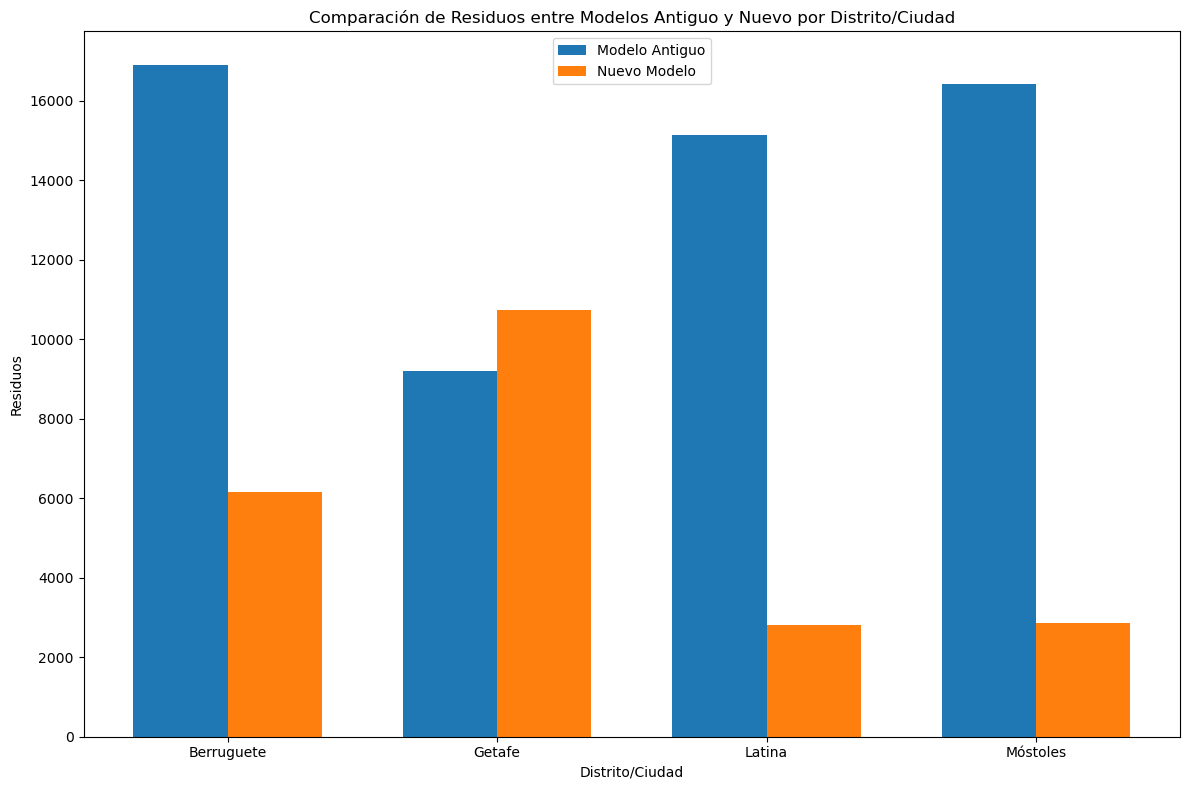

In [217]:
import matplotlib.pyplot as plt

# Crear una lista con los nombres de los distritos/ciudades
distritos = df['Distrito/Ciudad']

# Crear una lista con los residuos del modelo antiguo y del nuevo modelo
residuos_antiguo = df['Residuos_y']
residuos_nuevo = df['Residuos_x']

# Definir el ancho de las barras
ancho_barra = 0.35

# Definir la posición de las barras para cada distrito/ciudad
posicion = range(len(distritos))

# Graficar los residuos para cada distrito/ciudad
plt.figure(figsize=(12, 8))
plt.bar(posicion, residuos_antiguo, width=ancho_barra, label='Modelo Antiguo')
plt.bar([p + ancho_barra for p in posicion], residuos_nuevo, width=ancho_barra, label='Nuevo Modelo')

# Añadir etiquetas y título
plt.xlabel('Distrito/Ciudad')
plt.ylabel('Residuos')
plt.title('Comparación de Residuos entre Modelos Antiguo y Nuevo por Distrito/Ciudad')
plt.xticks([p + ancho_barra / 2 for p in posicion], distritos, rotation=0)
plt.legend()

# Mostrar la gráfica
plt.tight_layout()
plt.show()


## Heuristica

In [218]:
import numpy as np

# Paso 1: Calcular el precio por metro cuadrado para cada propiedad en tu conjunto de datos actual
DatosTrain['Precio_por_m2'] = DatosTrain['Precio'] / DatosTrain['Superficie']

# Paso 2: Calcular el precio por metro cuadrado promedio
precio_por_m2_promedio = np.mean(DatosTrain['Precio_por_m2'])

# Función para aplicar la heurística y calcular el precio estimado
def aplicar_heuristica(row):
    return row['Superficie'] * precio_por_m2_promedio

# Paso 3: Aplicar la heurística al otro conjunto de datos
DatosTest['Precio_estimado'] = DatosTest.apply(aplicar_heuristica, axis=1)
DatosTest["Residuo"] = np.abs(DatosTest['Precio'] - DatosTest['Precio_estimado'])

# Paso 4: Calcular el error absoluto medio
error_absoluto_medio = np.mean(np.abs(DatosTest['Precio'] - DatosTest['Precio_estimado']))

print("Error absoluto medio:", error_absoluto_medio)


Error absoluto medio: 66537.32069684553


In [219]:
df_heuristica =DatosTest.groupby("distrito/ciudad")["Residuo"].median().reset_index(name = "medianaResiduosHeurística")
df_modelo = datosTrainConResiduos.groupby("distrito/ciudad")["residuos"].median().reset_index(name = "medianaResiduosModelo")
df = pd.merge(df_heuristica,df_modelo, on = "distrito/ciudad")

In [220]:
import matplotlib.pyplot as plt

df_sorted = df.sort_values(by='medianaResiduosHeurística', ascending=False)

df_heuristica_mayor = df_sorted.head(10)

df_sorted = df.sort_values(by='medianaResiduosModelo', ascending=False)

df_modelo_mayor = df_sorted.head(10)

df_combined = pd.concat([df_heuristica_mayor, df_modelo_mayor])

df_combined = df_combined.sort_values(by='medianaResiduosHeurística', ascending=True)

In [221]:
df_combined.drop_duplicates(inplace = True)

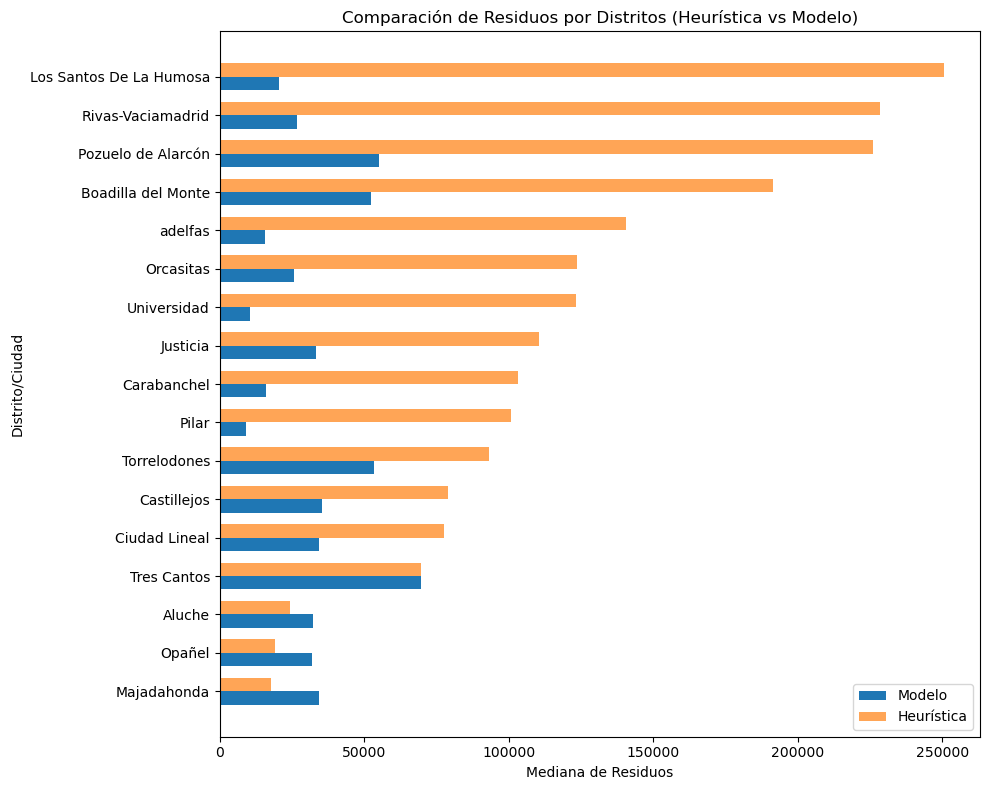

In [222]:
distritos = df_combined['distrito/ciudad']
medianas_residuos_heuristica = df_combined['medianaResiduosHeurística']
medianas_residuos_modelo = df_combined['medianaResiduosModelo']

posicion = range(len(distritos))

ancho_barra = 0.35

plt.figure(figsize=(10, 8))
plt.barh(posicion, medianas_residuos_modelo, height=ancho_barra, label='Modelo')
plt.barh([p + ancho_barra for p in posicion], medianas_residuos_heuristica, height=ancho_barra, alpha=0.7, label='Heurística')

plt.ylabel('Distrito/Ciudad')
plt.xlabel('Mediana de Residuos')
plt.title('Comparación de Residuos por Distritos (Heurística vs Modelo)')
plt.yticks([p + ancho_barra / 2 for p in posicion], distritos)
plt.legend()

plt.tight_layout()
plt.show()
